In [1]:
# since we work in a couple, we should check python version in advance and set it to 3.6.5
from platform import python_version
print(python_version())

3.6.6


# Introduction

X-ray imaging is one of the most widely used diagnostic examinations for the diagnosis and research of numerous types of illnesses, making it a high-potential source of data for the development of computer-aided detection and diagnosis tools.

The full dataset at hand is comprised of 112,120 chest X-ray images (in size 1024*1024) of 30,805 unique patients, which were classified into 14 different types of lung diseases (including images which demonstrate multiple diseases), and images of healthy individuals.

Several groups have addressed  this multi-label dataset in attempt to classify the images according to different research goals - some classified all 14 classes (diseases) [1],[2] or part of the diseases [3], some identified patients with one specific disease vs healthy patients, and some looked for the correlation between two (or more) diseases.

In this work we decided to simplify the problem and focus on classifying the images to patients who demonstrate Effusion (a fluid in the space around the lung), other diseases or healthy patients (3 classes). The main reason for this decision is the high frequency of the disease in the available dataset. Moreover, according to radiologist [4], this phenomena labeling seem to be more accurate than other diseases.

The image below represents eight common thoracic diseases [3].

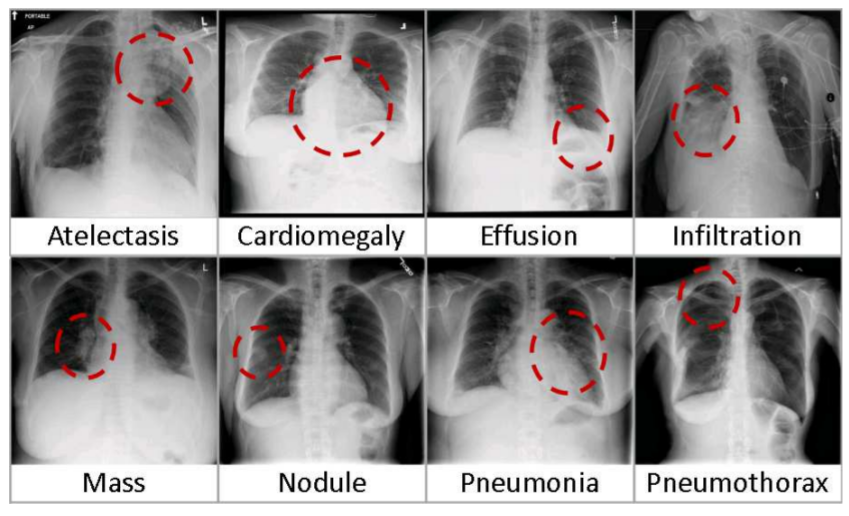

[1] Pranav Rajpurkar et al., CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning, (2017), URL https://arxiv.org/abs/1705.02315

[2] Pranav Rajpurkar et al., Deep learning for chest radiograph diagnosis: A retrospective comparison of the CheXNeXt algorithm to practicing radiologists, (2018), URL https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686

[3] Xiaosong Wang et al., ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases, (2017), URL http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

[4] Luke Oakden-Rayner, Exploring the ChestXray14 dataset: problems, (2017), URL https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/


# Import packages

In [2]:
# Load and group images
import os
from glob import glob
# Work with dataframes
import pandas as pd
# Image representation
import cv2
# Plot packages
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="darkgrid") # adds grid to seaborn's plots
# Random sampling
import random
import numpy as np


# Load input files

### Load images

In [3]:
# After extracting all images to a folder named 'images'
path = os.path.abspath(os.path.join('..', 'input'))
source_images = os.path.join(path, "sample", "images")
images = glob(os.path.join(source_images, "*.png"))

images[0:5]

['/kaggle/input/sample/images/00018731_001.png',
 '/kaggle/input/sample/images/00004203_000.png',
 '/kaggle/input/sample/images/00000417_001.png',
 '/kaggle/input/sample/images/00026033_000.png',
 '/kaggle/input/sample/images/00002623_000.png']

In [4]:
### ~~~ Use to check the running time of a procedure ~~~ ###
#import time

#start_time = time.time()

#print("--- %s seconds ---" % (time.time() - start_time))

### Load csv file

In [5]:
all_xray_df = pd.read_csv('../input/sample_labels.csv')

all_xray_df.sample(5)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2628,00013209_013.png,Pneumothorax,13,13209,074Y,F,PA,2992,2991,0.143,0.143
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143
2292,00011723_001.png,Atelectasis|Infiltration,1,11723,062Y,M,AP,2500,2048,0.168,0.168
3213,00015814_003.png,Atelectasis,3,15814,030Y,F,AP,2500,2048,0.168,0.168
496,00002570_007.png,No Finding,7,2570,075Y,M,AP,2500,2048,0.168,0.168


### Represent 3 random images to validate the loading process

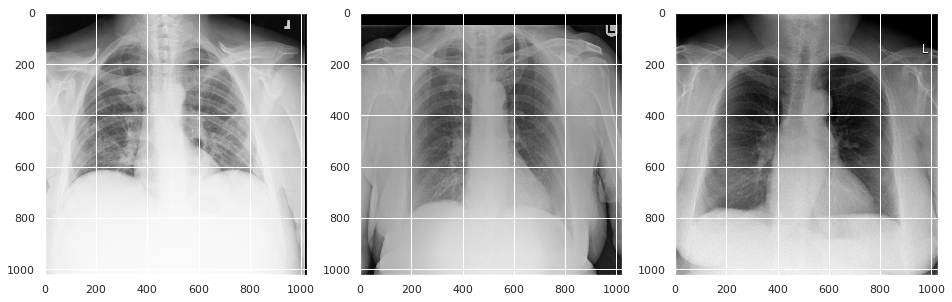

In [6]:
r = random.sample(images, 3)

fig = plt.figure(figsize=(16,16))

plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]))
plt.show()

# Explanatory Data Analysis (EDA) + Pre-processing

### Pre-processing - Keep relevant columns

The original data included 4 additional columns with parameters which describe the original size of the images (weight, height, etc.).
We currently want to remove these known parameters since the images have been resized to 1024*1024 and we may be interested mainly in the rest of the variables.

In [7]:
all_xray_df['Patient Age']=all_xray_df['Patient Age'].apply(lambda x: x[:-1]).astype(int)


In [8]:
all_xray_df = all_xray_df[['Image Index','Finding Labels','Follow-up #',
                           'Patient ID','Patient Age','Patient Gender','View Position']]

In [9]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP
2,00000017_001.png,No Finding,1,17,77,M,AP
3,00000030_001.png,Atelectasis,1,30,79,M,PA
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP


### Describe all parameters to understand data and search for missing values

In [10]:
all_xray_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
count,5606,5606,5606.000000,5606.000000,5606.000000,5606,5606
unique,5606,244,NaN,NaN,NaN,2,2
top,00013931_002.png,No Finding,NaN,NaN,NaN,M,PA
freq,1,3044,NaN,NaN,NaN,3134,3393
mean,NaN,NaN,8.616661,14330.617017,46.770068,NaN,NaN
std,NaN,NaN,15.565815,8411.477789,17.407436,NaN,NaN
min,NaN,NaN,0.000000,13.000000,1.000000,NaN,NaN
25%,NaN,NaN,0.000000,7289.000000,35.000000,NaN,NaN
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN
75%,NaN,NaN,10.000000,20655.500000,59.000000,NaN,NaN


In [124]:
all_xray_df['Patient ID'].unique

<bound method Series.unique of 0          13
1          13
2          17
3          30
4          32
5          40
6          42
7          57
8          61
9          61
10         61
11         79
12         80
13         83
14         84
15         96
16         99
17         99
18        103
19        116
20        116
21        116
22        116
23        118
24        121
25        127
26        132
27        154
28        165
29        175
        ...  
5576    30439
5577    30455
5578    30471
5579    30495
5580    30520
5581    30532
5582    30532
5583    30545
5584    30565
5585    30573
5586    30588
5587    30606
5588    30609
5589    30634
5590    30635
5591    30635
5592    30636
5593    30636
5594    30636
5595    30636
5596    30636
5597    30639
5598    30650
5599    30695
5600    30704
5601    30712
5602    30786
5603    30789
5604    30792
5605    30797
Name: Patient ID, Length: 5606, dtype: int64>

As represented in the table above, there are no missing values for all variables (both categorical and numerical).

According to 'Patient ID', the database includes 112,120 x-ray images of 30,805 unique patients.

It can be observed that 60,361 out of 112,120 images represent healthy subjects ('No Finding'). 
Moreover, 56% of the subjects are males and 60% of the images' view position is posterioranterior (PA, when patient's back faces the machine).

It can also be observed that there are outliers of patient age, since 414 years is the maximal value, and that the follow-up median # is 3, while the mean is 8.5, meaning the distribution is not normal.

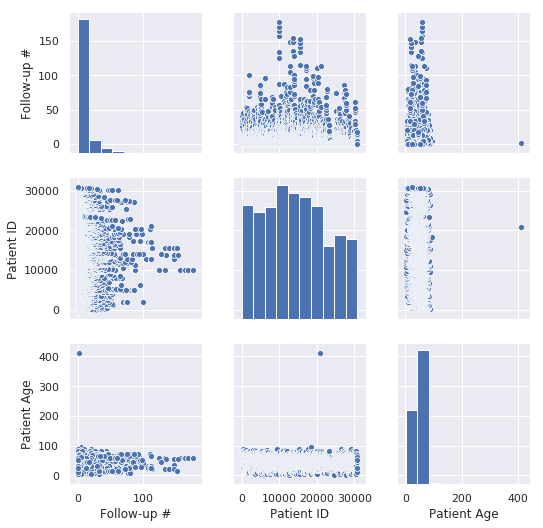

In [11]:
# Represent relations between the numerical variables by representing distributions
sns.pairplot(all_xray_df)
plt.show()

According to the pairplot, there are 5 images with patient age over 400, and another 10 images having age above 100.
Moreover, there is no significant correlation between the follow up # and the patient age.

Yet, since we currently are interested in classifying only the images data, we decided not to remove the outliers of the 'age' variables, since we do not mind that they were mistakenly documented.

## Understand the data in matters of the amount of each pathology

In [12]:
# List of pathologies

list_pathology = ['Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
                  'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
                  'Cardiomegaly','Nodule','Mass','Hernia','No Finding']

In [13]:
# Create a column 0f 0/1 for each desease

for pathology in list_pathology :
    all_xray_df[pathology] = all_xray_df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

In [14]:
# create a new df that includes the image index and the count (0/1) of each pathology for each image

separate_disease = pd.melt(all_xray_df, id_vars=['Image Index'], value_vars = list_pathology,
                           var_name = 'Pathology', value_name = 'Count' )
# keep rows that represent a disease
separate_disease = separate_disease.loc[separate_disease.Count>0]

# print for convience
print( separate_disease.head() )
print( separate_disease.shape )

          Image Index    Pathology  Count
3    00000030_001.png  Atelectasis      1
29   00000175_001.png  Atelectasis      1
30   00000175_002.png  Atelectasis      1
47   00000248_020.png  Atelectasis      1
118  00000642_000.png  Atelectasis      1
(6978, 3)


In [15]:
# save the amount of each pathology in a descending order
disease_freq = separate_disease.groupby('Pathology')['Count'].sum()
disease_freq = disease_freq.sort_values(axis=0, ascending=False)

# remove 'No finding' (60,391 cases), since we are mainly interested in the pathologies
disease_freq = disease_freq.drop( ['No Finding'] )

# print for convience
disease_freq

Pathology
Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Pleural_Thickening    176
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
Name: Count, dtype: int64

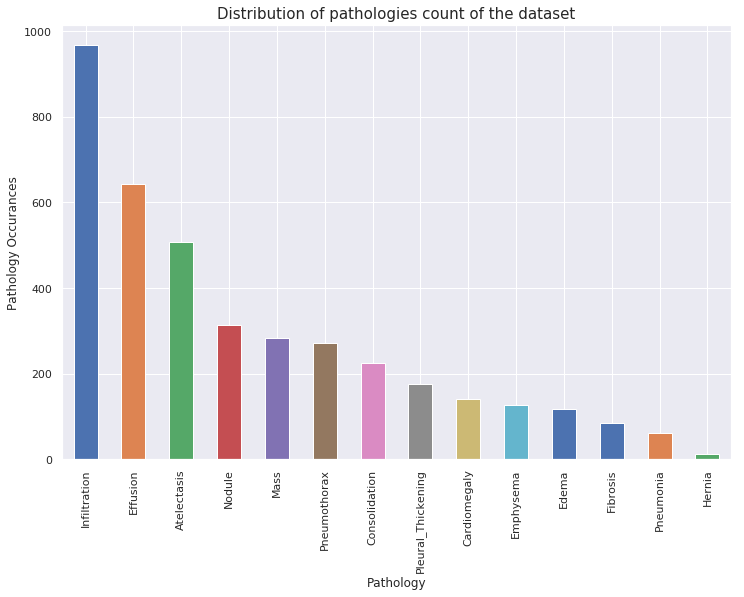

In [16]:
# plot
plt.figure(figsize=(12,8))

disease_freq.plot(kind='bar')
plt.ylabel('Pathology Occurances')
plt.title('Distribution of pathologies count of the dataset',fontsize=15)
plt.show()


According to the above we can see that 'Effusion' is one of the most common observations in this dataset, therefore we have decided to classify the data to the 3 following catagories: Effusion (1), Other disease (2), Healthy (3)

### Pre-processing - Prepare a labels (Y) column with 3 classes - Effusion (1), Other disease (2), Healthy (3)

Creation of a new parameter called '3class_label':

In [17]:
# Create new column ('3class_label')

def new_label(row):
    if row['No Finding'] == 1:
        return 3
    elif row['Effusion'] == 1:
        return 1
    return 2
  
all_xray_df['3class_label'] = all_xray_df.apply( lambda row: new_label(row),axis=1 )
#all_xray_df['3class_label']= all_xray_df['3class_label'].astype(str)

In [18]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding,3class_label
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,2
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2
2,00000017_001.png,No Finding,1,17,77,M,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,00000030_001.png,Atelectasis,1,30,79,M,PA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1


## Parameters distribution between the 3 new catagories 

### Images Distribution

In [19]:
class_size = all_xray_df.groupby('3class_label').size().reset_index(name='size')
class_size

,3class_label,size
0,1,644
1,2,1918
2,3,3044


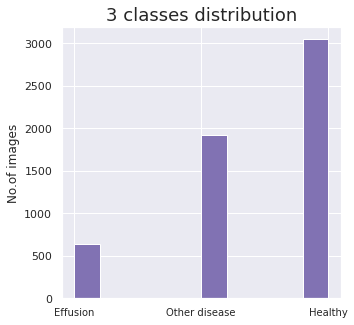

In [20]:
# Plot amount of 3 labels
all_xray_df[['3class_label']].hist(figsize = (5, 5), color='C4')
plt.xticks([1,2,3],['Effusion','Other disease','Healthy'], fontsize=10)
plt.title('3 classes distribution', fontsize=18)
plt.ylabel("No.of images")
plt.show()

After the re-classicifation we now have: 
644 images of 'Effusion', 1,918 Images of 'Other diseases' and 3,044 'Healthy' images.

### Distribution of View Position (PA/AP) / Gender

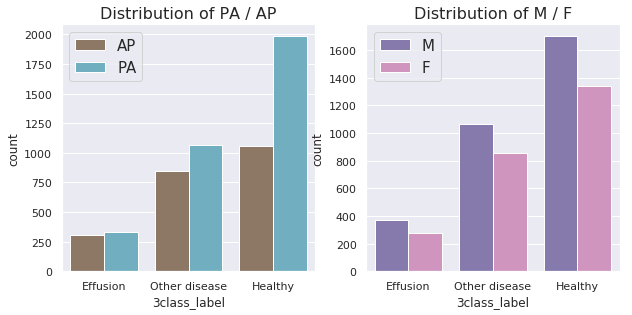

In [21]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,2,1)
g=sns.countplot(x='3class_label', hue='View Position', data=all_xray_df, ax=ax, palette=["C5", "C9"]) # palette - colors
plt.xticks([0,1,2],['Effusion','Other disease','Healthy'])
ax.legend(fontsize=15)
ax.set_title('Distribution of PA / AP',fontsize=16)

ax1 = fig.add_subplot(2,2,2)
g=sns.countplot(x='3class_label', hue='Patient Gender', data=all_xray_df, ax=ax1, palette=["C4", "C6"])
plt.xticks([0,1,2],['Effusion','Other disease','Healthy'])
ax1.legend(fontsize=15)
ax1.set_title('Distribution of M / F',fontsize=16)
plt.show()


### Disease occurances according to M/F population

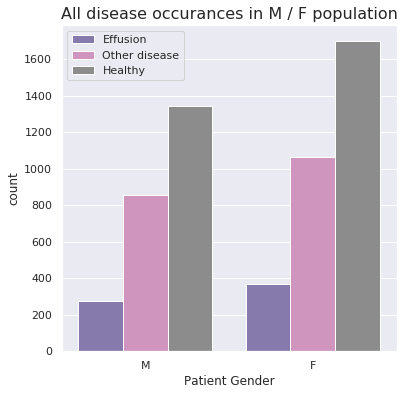

In [22]:
plt.figure(figsize=(6,6))
# Run the following row for the first time only!
all_xray_df['Patient Gender'].replace({'F':0,'M':1},inplace=True)

g=sns.countplot(x='Patient Gender', hue='3class_label', data=all_xray_df, palette=["C4", "C6","C7"])
plt.xticks([0,1],['M','F'])
plt.legend(('Effusion','Other disease','Healthy'))
plt.title('All disease occurances in M / F population',fontsize=16)
plt.show()

We can see there is no significant correlation between the X-ray position (PA/ AP) and the patient gender and the detection of 'Effusion'. 

### Age distribution of classes

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


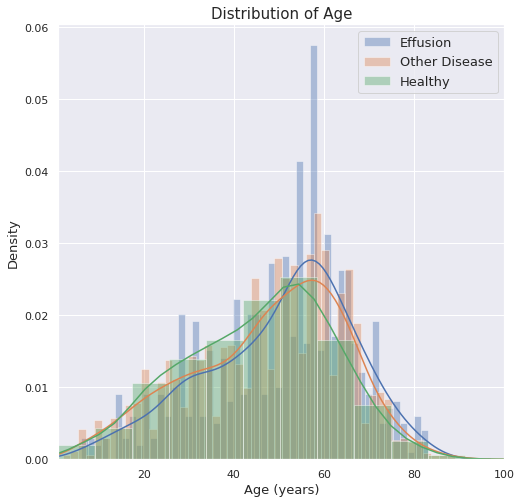

In [23]:
target_1 = all_xray_df.loc[all_xray_df['3class_label'] == 1]
target_2 = all_xray_df.loc[all_xray_df['3class_label'] == 2]
target_3 = all_xray_df.loc[all_xray_df['3class_label'] == 3]

plt.figure(figsize=(8,8))

f = sns.distplot(target_1[['Patient Age']], hist=True, bins=50, label='Effusion' )
sns.distplot(target_2[['Patient Age']], hist=True, bins=50, label='Other Disease')
sns.distplot(target_3[['Patient Age']], hist=True, bins=50, label='Healthy')
f.set_xlim(1,100)

plt.xlabel('Age (years)',fontsize=13)
plt.ylabel('Density',fontsize=13)
plt.title('Distribution of Age',fontsize=15)

plt.legend(fontsize=13)
plt.show()

### Follow-up # distribution

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


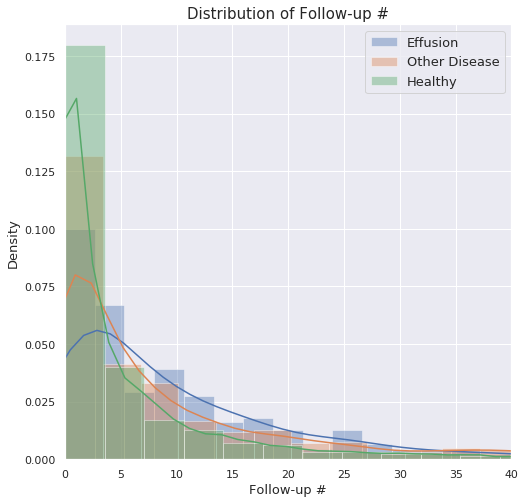

In [24]:
target_1 = all_xray_df.loc[all_xray_df['3class_label'] == 1]
target_2 = all_xray_df.loc[all_xray_df['3class_label'] == 2]
target_3 = all_xray_df.loc[all_xray_df['3class_label'] == 3]

plt.figure(figsize=(8,8))

f = sns.distplot(target_1[['Follow-up #']], hist=True, bins=50, label='Effusion' )
sns.distplot(target_2[['Follow-up #']], hist=True, bins=50, label='Other Disease')
sns.distplot(target_3[['Follow-up #']], hist=True, bins=50, label='Healthy')
f.set_xlim(0,40)

plt.xlabel('Follow-up #',fontsize=13)
plt.ylabel('Density',fontsize=13)
plt.title('Distribution of Follow-up #',fontsize=15)

plt.legend(fontsize=13)
plt.show()

## Images Analysis

### Represent random images with labels

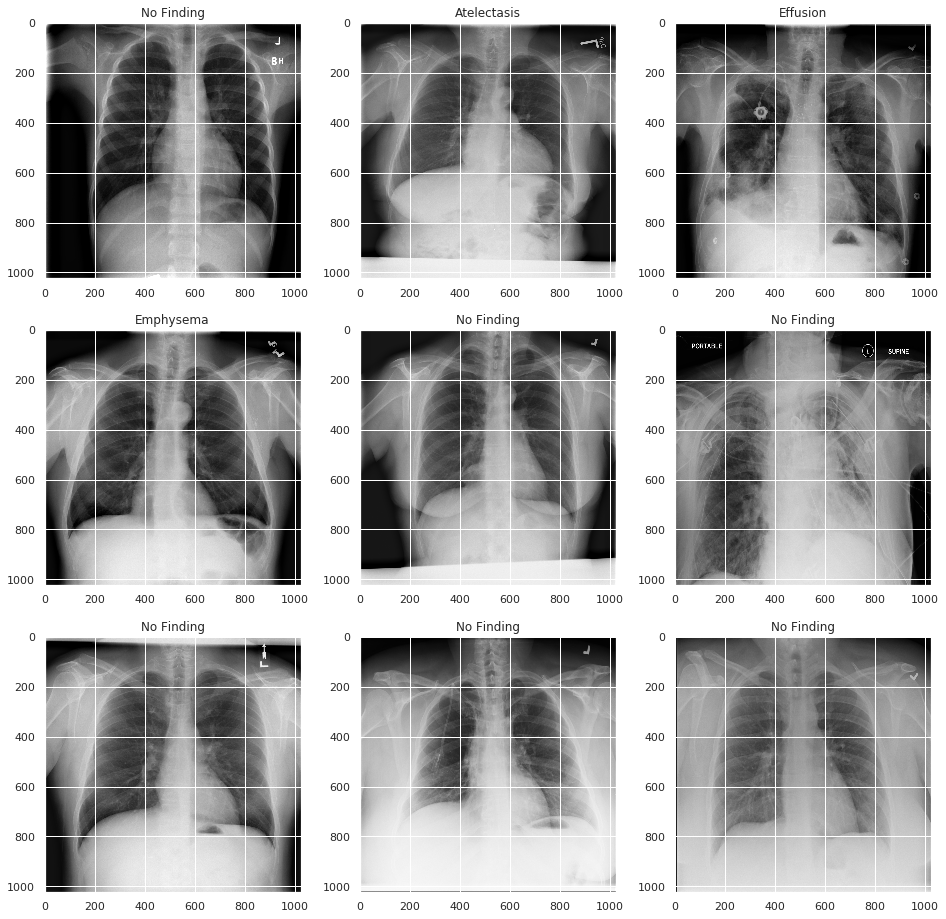

In [25]:
# Random sampling of 9 images
r = random.sample(images, 9)

fig = plt.figure(figsize=(16,16))

for i in range(9):
    img = cv2.imread(r[i])
    # image name
    file_name = os.path.basename(r[i])         
    # find image label 
    label_image = all_xray_df.loc[all_xray_df['Image Index'] == file_name, 'Finding Labels'].iloc[0]           

    ax = fig.add_subplot(3,3,i+1)                                                  
    ax.set_title( label_image )
    ax.imshow( img )

plt.show()


The representative images are examples of the reason that data augmentation may be usefull with such a data set.

### Pixels Histograms of representative images

In [136]:
r = ['kaggle/input/sample/images/00000017_001.png',
    'kaggle/input/sample/images/00000061_002.png']

def plotHistogram(x,title_var):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.title(title_var)
    a= cv2.imread(x)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)
    
#plotHistogram(r[0],'Representative Image of healty patient')
#plotHistogram(r[1],'Representative Image of patient with Effusion')

#plt.show()

## Prepare data for training process

We currently decided to simplify even more and try to classify 1 for 'Effusion' occurance or 0 for 'healthy'.
Therefore, we take all the 'effusion' data we have (644), and twice this number we sample randomly from the 'healthy' population (1,300). 

In [30]:
#Reduce the amount of images labeled as 'healthy'
df_healthy = all_xray_df[all_xray_df['3class_label'] == 3].sample(1300)
#Append the effusion labeled 
final_df = df_healthy.append(all_xray_df[all_xray_df['3class_label'] == 1])
final_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding,3class_label
237,00001280_002.png,No Finding,2,1280,35,0,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
2211,00011395_000.png,No Finding,0,11395,32,0,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
4539,00022684_006.png,No Finding,6,22684,45,1,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
2890,00014256_002.png,No Finding,2,14256,69,1,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
4307,00021239_010.png,No Finding,10,21239,50,1,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
1989,00010398_000.png,No Finding,0,10398,57,1,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
609,00003129_000.png,No Finding,0,3129,61,1,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
2601,00013066_000.png,No Finding,0,13066,44,1,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3484,00017138_113.png,No Finding,113,17138,24,1,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
1155,00006098_001.png,No Finding,1,6098,20,0,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


In [31]:
#image_index = final_df['Image Index']
#image_index.head(10)

# Split to Train, Validation and Test

In [32]:
from sklearn.model_selection import train_test_split
train_set, test_set= train_test_split(final_df, test_size = 0.1, random_state = 1678)
train_set, val_set= train_test_split(train_set, test_size = 0.1, random_state = 1678)

print('Full data set:', len(final_df))
print('Training set: ', len(train_set))
print('Validation set: ', len(val_set))
print('Test set:', len(test_set))


Full data set: 1944
Training set:  1574
Validation set:  175
Test set: 195


### Check distribution in groups

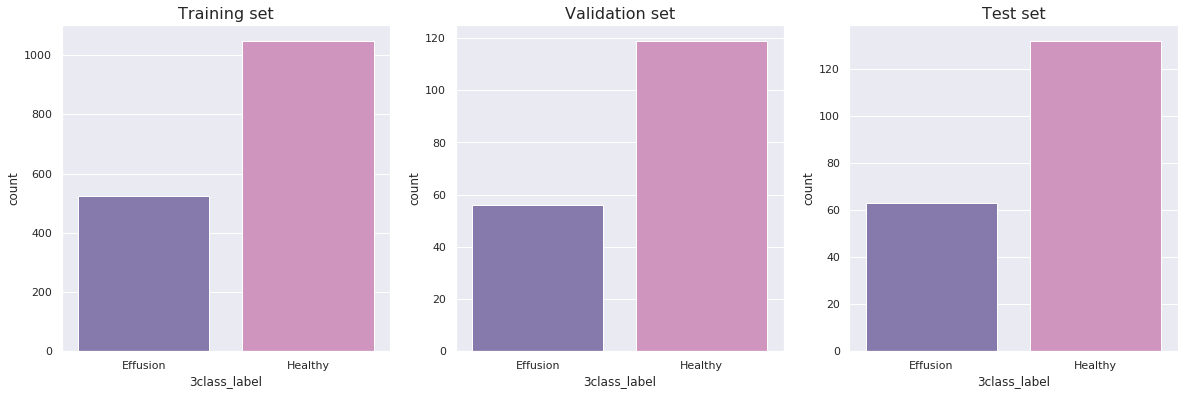

In [33]:
fig = plt.figure(figsize=(20,6))

ax = fig.add_subplot(1,3,1)
g=sns.countplot(x='3class_label', data=train_set, palette=["C4", "C6"]) 
plt.xticks([0,1],['Effusion','Healthy'])
ax.set_title('Training set',fontsize=16)

ax1 = fig.add_subplot (1,3,2)
g=sns.countplot(x='3class_label', data=val_set, palette=["C4", "C6"])
ax1.set_title('Validation set',fontsize=16)
plt.xticks([0,1],['Effusion','Healthy'])

ax2 = fig.add_subplot(1,3,3)
g=sns.countplot(x='3class_label', data=test_set, palette=["C4", "C6"])
ax2.set_title('Test set',fontsize=16)
plt.xticks([0,1],['Effusion','Healthy'])

plt.show()

In [34]:
print ('Count of Effusion in training set:', (len(train_set[train_set['3class_label'] == 1])))
print ('Count of Healthy in training set:', (len(train_set[train_set['3class_label'] == 3])))

Count of Effusion in training set: 525
Count of Healthy in training set: 1049


### Create balanced training group

Due to limited computational resources, in this case, we decided to randomaly reduce the bigger group ('Healthy') to match the size of the minority group ('Effusion'), rather then using data augmentation techniques to enlrage the smaller group.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa98f58a6a0>]],
      dtype=object)

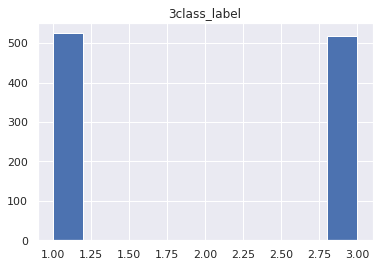

In [35]:
# Reduce the amount of images labeled as 'healthy'
train_set_healthy  = train_set[train_set['3class_label'] == 3].sample(519)
# Append the effusion labeled 
train_set_balanced = train_set_healthy.append(train_set[train_set['3class_label'] == 1])
train_set_balanced[['3class_label']].hist()

### Standartizaion and normalization of images

In [36]:
#Images pre-processing and standartization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input 
datagen=ImageDataGenerator(samplewise_center=False, # default
                              samplewise_std_normalization=False, # default
                              horizontal_flip=False, # default
                              vertical_flip=False, # default
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              brightness_range=[0.7, 1.5],
                              rotation_range=3, 
                              shear_range=0.01,
                              fill_mode='nearest', # default. Type of padding outside the input boundaries
                              zoom_range=0.125, # Standardzing zoom
                              rescale=1/255.0, # Rescaling pixels to be between 0-1
                              preprocessing_function=preprocess_input) # the image pixels need to be prepared in the same way as the ImageNet training data was prepared

Using TensorFlow backend.


In [37]:
# Switch to type string in order to work with categorical binary classification
train_set_balanced['3class_label']=train_set_balanced['3class_label'].astype(str)

### Create images and their groud-truth labels for the training, validation and test groups

In [38]:
# Creation of images arrays of the training group
train_generator=datagen.flow_from_dataframe(dataframe=train_set_balanced, 
                                            directory=source_images, 
                                            x_col="Image Index", 
                                            y_col="3class_label", 
                                            class_mode="categorical", 
                                            target_size=(256,256)) # Resizing images to 256X256
                                           

Found 1044 images belonging to 2 classes.


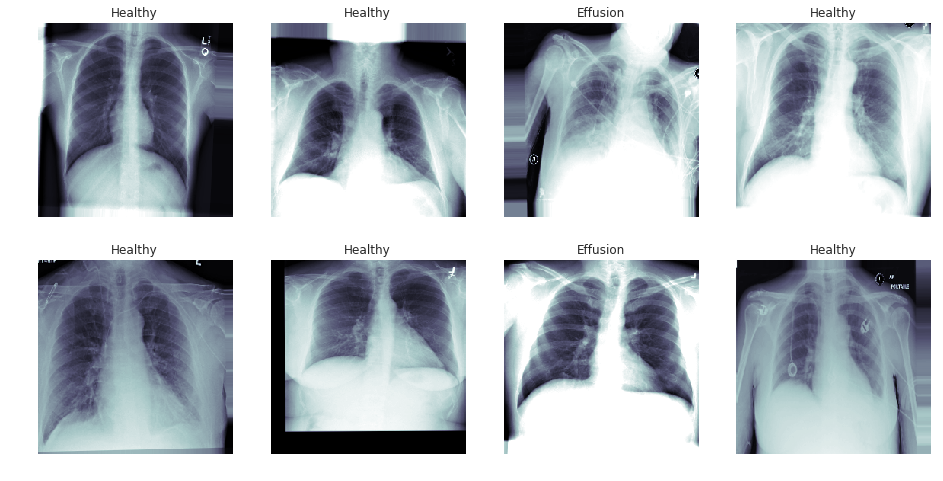

In [39]:
# Test - check that the function flow_from_dataframe matches an image with its label
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % ('Effusion' if c_y[0]==1 else 'Healthy'))
    c_ax.axis('off')
   

In [40]:
#Creation of images arrays of the validation group
val_set['3class_label']=val_set['3class_label'].astype(str)
val_set = val_set.reset_index()
val_generator=datagen.flow_from_dataframe(dataframe=val_set, 
                                            directory=source_images, 
                                            x_col="Image Index", 
                                            y_col="3class_label", 
                                            class_mode="categorical",
                                            batch_size=175,
                                            target_size=(256,256))  # Resizing images to 256X256

#Defining the X,Y test sets
val_X, val_Y = next(val_generator)                              

Found 175 images belonging to 2 classes.


In [41]:
#Creation of images arrays of the test group
test_set['3class_label']=test_set['3class_label'].astype(str)
test_generator=datagen.flow_from_dataframe(dataframe=test_set, 
                                            directory=source_images, 
                                            x_col="Image Index",
                                            y_col="3class_label", 
                                            class_mode="categorical",
                                            batch_size=195,
                                            target_size=(256,256))# Resizing images to 256X256

#Defining the X,Y test sets
test_X, test_Y = next(test_generator)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Found 195 images belonging to 2 classes.


#  Continued Training with VGG16

### Another attempt at VGG16 with dense layer of Sigmoid activation and Adam optimizer

In [65]:
from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import adagrad, RMSprop, adam

model_c = Sequential( )
base_model = VGG16(input_shape = (256,256,3), 
                              include_top = False, weights = 'imagenet')
model_c.add(base_model)
base_model.trainable = False

# Add relevant layers to improve classification task
model_c.add(Flatten())
model_c.add(Dense(1000, activation = 'sigmoid')) #ReLu was replaced with Sigmoid activation
model_c.add(BatchNormalization())
model_c.add(Dropout(0.2))
#model_a.add(Dense(units=2,activation='sigmoid'))
model_c.add(Dense(2, activation = 'softmax'))

print(model_c.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              32769000  
_________________________________________________________________
batch_normalization_5 (Batch (None, 1000)              4000      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 2002      
Total params: 47,489,690
Trainable params: 32,773,002
Non-trainable params: 14,716,688
_______________________________________________________

In [66]:
#Compaile the model to configure the learning process
model_c.compile(loss='binary_crossentropy', optimizer=adam(lr=0.001), metrics=['binary_accuracy'])

## Define callbacks to improve efficiency

In [67]:
#Define callbacks to improve the model's efficiancy 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_c="{}_weights.best.c.hdf5".format('model_c')

checkpoint_c = ModelCheckpoint(weight_c, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, mode='auto', min_lr=0.00001)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)

callbacks_list = [checkpoint_c, early, reduceLROnPlat]

## Train the model on the training data-set

In [68]:
#Fit the model
his = model_c.fit_generator(train_generator, 
                      validation_data = (val_X, val_Y), 
                      epochs = 30, 
                      steps_per_epoch= 42,
                      callbacks = callbacks_list)

Epoch 1/30
42/42 [==============================] - 44s 1s/step - loss: 1.3595 - binary_accuracy: 0.6747 - val_loss: 0.9804 - val_binary_accuracy: 0.4514

Epoch 00001: val_loss improved from inf to 0.98040, saving model to model_a_weights.best.c.hdf5
Epoch 2/30
42/42 [==============================] - 42s 1s/step - loss: 0.5264 - binary_accuracy: 0.7437 - val_loss: 0.6353 - val_binary_accuracy: 0.6857

Epoch 00002: val_loss improved from 0.98040 to 0.63535, saving model to model_a_weights.best.c.hdf5
Epoch 3/30
42/42 [==============================] - 42s 1s/step - loss: 0.4939 - binary_accuracy: 0.7653 - val_loss: 0.5105 - val_binary_accuracy: 0.7714

Epoch 00003: val_loss improved from 0.63535 to 0.51052, saving model to model_a_weights.best.c.hdf5
Epoch 4/30
42/42 [==============================] - 42s 994ms/step - loss: 0.4665 - binary_accuracy: 0.7790 - val_loss: 0.5825 - val_binary_accuracy: 0.7257

Epoch 00004: val_loss did not improve from 0.51052
Epoch 5/30
42/42 [============

In [69]:
model_c.load_weights(weight_c)

## Predict labels for the test-set

In [70]:
#Predict
pred_Y = model_c.predict(test_X, 
                          verbose = True)

195/195 [==============================] - 1s 5ms/step


# Visualizations of results

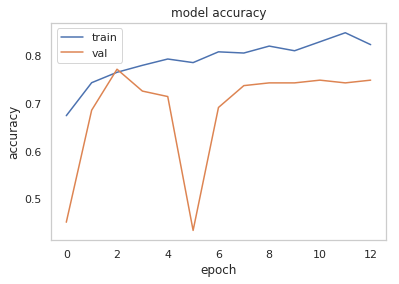

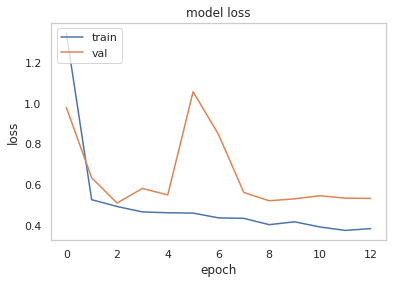

In [143]:
# Change of training and validation loss and accuracy for each epoch
def history_plot(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
history_plot(his)

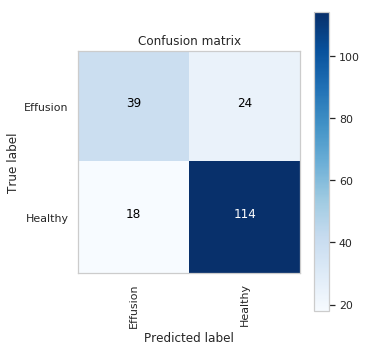

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

# Confusion matrix
sns.set_style("whitegrid", {'axes.grid' : False})

cm=confusion_matrix(test_Y.argmax(axis=1),pred_Y.argmax(axis=1))
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
dict_pathology = {0: 'Effusion',1:'Healthy'}
plot_confusion_matrix(cm, classes = list(dict_pathology.values()))

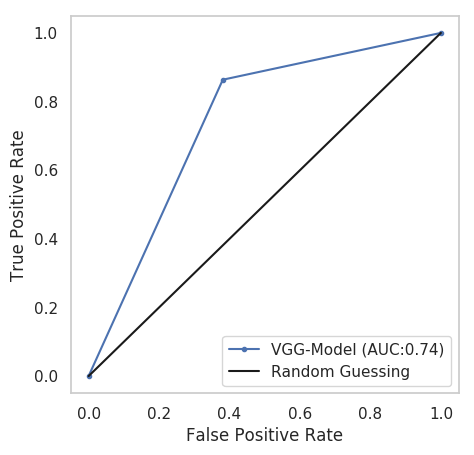

In [73]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y.argmax(axis=1), pred_Y.argmax(axis=1))
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y.argmax(axis=1), pred_Y.argmax(axis=1)))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')

In [74]:
# Classification report - precision and recall
pred_Y[pred_Y>0.5] = 1 # Switch from probabilities to class
pred_Y[pred_Y<=0.5] = 0
print(classification_report(test_Y, pred_Y, target_names = ['Effusion', 'Healthy']))

              precision    recall  f1-score   support

    Effusion       0.68      0.62      0.65        63
     Healthy       0.83      0.86      0.84       132

   micro avg       0.78      0.78      0.78       195
   macro avg       0.76      0.74      0.75       195
weighted avg       0.78      0.78      0.78       195
 samples avg       0.78      0.78      0.78       195



## Continued training with saved model weights

In [134]:
his_2 = model_c.fit_generator(train_generator, 
                      validation_data = (val_X, val_Y), 
                      epochs = 30, 
                      steps_per_epoch= 42,
                      callbacks = callbacks_list)

Epoch 1/30
42/42 [==============================] - 42s 1s/step - loss: 0.4539 - binary_accuracy: 0.7952 - val_loss: 0.9361 - val_binary_accuracy: 0.5086

Epoch 00001: val_loss did not improve from 0.51052
Epoch 2/30
42/42 [==============================] - 42s 1s/step - loss: 0.4475 - binary_accuracy: 0.8034 - val_loss: 0.7316 - val_binary_accuracy: 0.6343

Epoch 00002: val_loss did not improve from 0.51052
Epoch 3/30
42/42 [==============================] - 42s 999ms/step - loss: 0.4626 - binary_accuracy: 0.7948 - val_loss: 0.6691 - val_binary_accuracy: 0.6343

Epoch 00003: val_loss did not improve from 0.51052
Epoch 4/30
42/42 [==============================] - 41s 985ms/step - loss: 0.4401 - binary_accuracy: 0.7966 - val_loss: 0.6148 - val_binary_accuracy: 0.6686

Epoch 00004: val_loss did not improve from 0.51052
Epoch 5/30
42/42 [==============================] - 42s 992ms/step - loss: 0.4583 - binary_accuracy: 0.8001 - val_loss: 0.5731 - val_binary_accuracy: 0.7086

Epoch 00005:

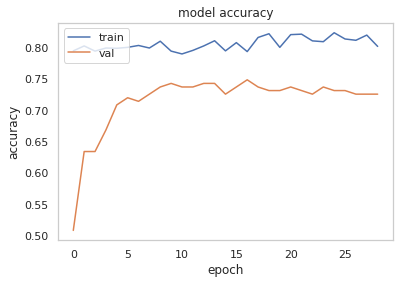

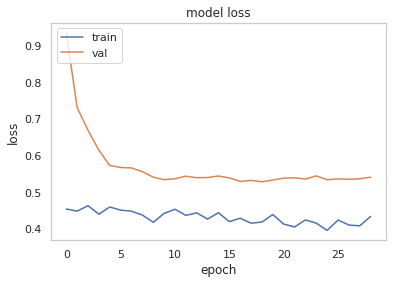

In [144]:
history_plot(his_2)

In [138]:
pred_Y = model_c.predict(test_X, 
                          verbose = True)

195/195 [==============================] - 1s 4ms/step


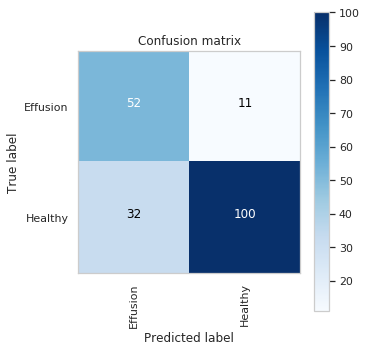

In [139]:
cm=confusion_matrix(test_Y.argmax(axis=1),pred_Y.argmax(axis=1))
plot_confusion_matrix(cm, classes = list(dict_pathology.values()))


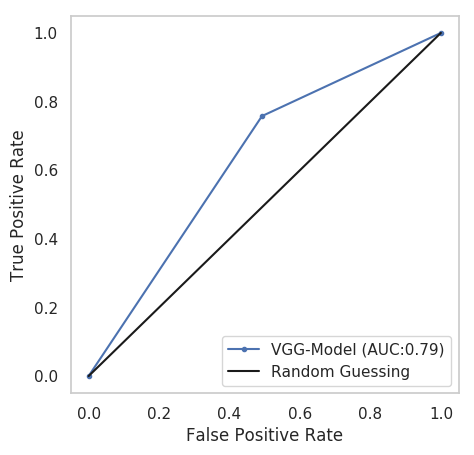

In [140]:
pr, tpr, _ = roc_curve(test_Y.argmax(axis=1), pred_Y.argmax(axis=1))
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y.argmax(axis=1), pred_Y.argmax(axis=1)))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')

In [141]:
pred_Y[pred_Y>0.5] = 1 # Switch from probabilities to class
pred_Y[pred_Y<=0.5] = 0
print(classification_report(test_Y, pred_Y, target_names = ['Effusion', 'Healthy']))

              precision    recall  f1-score   support

    Effusion       0.62      0.83      0.71        63
     Healthy       0.90      0.76      0.82       132

   micro avg       0.78      0.78      0.78       195
   macro avg       0.76      0.79      0.77       195
weighted avg       0.81      0.78      0.79       195
 samples avg       0.78      0.78      0.78       195



## Same Model Architechture with VGG19 as Base Model

In [120]:
from keras.applications.vgg19 import VGG19
model_s = Sequential( )
base_model_s = VGG19(input_shape = (256,256,3), 
                              include_top = False, weights = 'imagenet')
model_s.add(base_model_s)
base_model_s.trainable = False

# Add relevant layers to improve classification task
model_s.add(Flatten())
model_s.add(Dense(1000, activation = 'sigmoid'))
model_s.add(BatchNormalization())
model_s.add(Dropout(0.2))
#model_f.add(Dense(units=2,activation='sigmoid'))
model_s.add(Dense(2, activation = 'softmax'))

print(model_s.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_17 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 1000)              32769000  
_________________________________________________________________
batch_normalization_13 (Batc (None, 1000)              4000      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 2002      
Total params: 52,799,386
Trainable params: 32,773,002
Non-trainable params: 20,026,384
_______________________________________________________

In [121]:
weight_s="{}_weights.best.9.hdf5".format('model_s')

checkpoint_s = ModelCheckpoint(weight_s, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, mode='auto')

callbacks_list_model_s = [checkpoint_s, early, reduceLROnPlat]

In [122]:
model_s.compile(loss='binary_crossentropy', optimizer=adam(lr=0.001), metrics=['binary_accuracy'])

In [123]:
his_s = model_s.fit_generator(train_generator, 
                      validation_data = (val_X, val_Y), 
                      epochs = 30, 
                      steps_per_epoch= 42,
                      callbacks = callbacks_list_model_s)

Epoch 1/30
42/42 [==============================] - 46s 1s/step - loss: 1.2113 - binary_accuracy: 0.6888 - val_loss: 5.1214 - val_binary_accuracy: 0.6800

Epoch 00001: val_loss improved from inf to 5.12140, saving model to model_s_weights.best.9.hdf5
Epoch 2/30
42/42 [==============================] - 39s 932ms/step - loss: 0.5517 - binary_accuracy: 0.7369 - val_loss: 2.1410 - val_binary_accuracy: 0.6800

Epoch 00002: val_loss improved from 5.12140 to 2.14096, saving model to model_s_weights.best.9.hdf5
Epoch 3/30
42/42 [==============================] - 42s 1s/step - loss: 0.5177 - binary_accuracy: 0.7582 - val_loss: 0.8003 - val_binary_accuracy: 0.6857

Epoch 00003: val_loss improved from 2.14096 to 0.80026, saving model to model_s_weights.best.9.hdf5
Epoch 4/30
42/42 [==============================] - 42s 1s/step - loss: 0.5268 - binary_accuracy: 0.7537 - val_loss: 0.5364 - val_binary_accuracy: 0.7143

Epoch 00004: val_loss improved from 0.80026 to 0.53642, saving model to model_s_w

In [125]:
model_s.load_weights(weight_s)

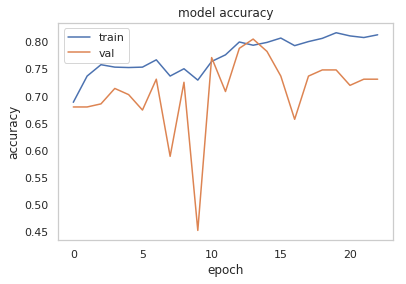

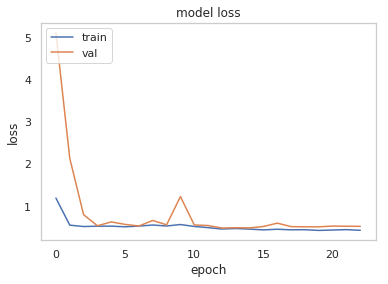

In [145]:
history_plot(his_s)


In [127]:
pred_Y_s = model_s.predict(test_X, 
                          verbose = True)


195/195 [==============================] - 3s 14ms/step


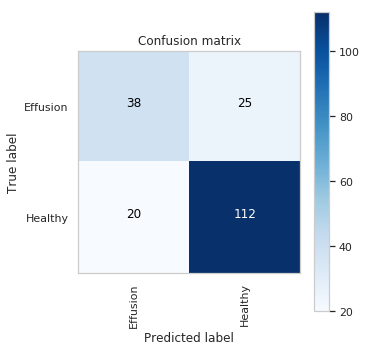

In [128]:
cm=confusion_matrix(test_Y.argmax(axis=1),pred_Y_s.argmax(axis=1))
plot_confusion_matrix(cm, classes = list(dict_pathology.values()))


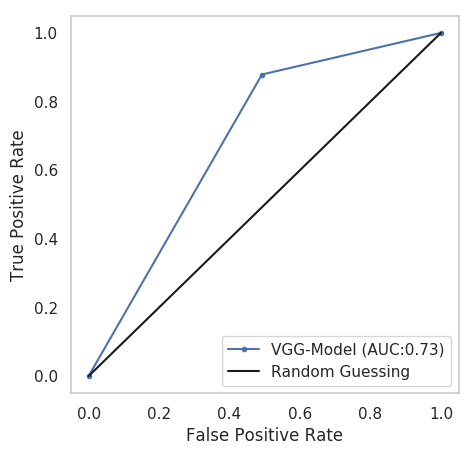

In [129]:
fpr, tpr, _ = roc_curve(test_Y.argmax(axis=1), pred_Y_d.argmax(axis=1))
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y.argmax(axis=1), pred_Y_s.argmax(axis=1)))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')

In [130]:
pred_Y_s[pred_Y_s>0.5] = 1 # Switch from probabilities to class
pred_Y_s[pred_Y_s<=0.5] = 0
print(classification_report(test_Y, pred_Y_s, target_names = ['Effusion', 'Healthy']))

              precision    recall  f1-score   support

    Effusion       0.66      0.60      0.63        63
     Healthy       0.82      0.85      0.83       132

   micro avg       0.77      0.77      0.77       195
   macro avg       0.74      0.73      0.73       195
weighted avg       0.77      0.77      0.77       195
 samples avg       0.77      0.77      0.77       195



### Continued training with saved weights

In [131]:
his_s_2 = model_s.fit_generator(train_generator, 
                      validation_data = (val_X, val_Y), 
                      epochs = 15, 
                      steps_per_epoch= 50,
                      callbacks = callbacks_list_model_s)

Epoch 1/15
50/50 [==============================] - 51s 1s/step - loss: 0.4580 - binary_accuracy: 0.8030 - val_loss: 0.4762 - val_binary_accuracy: 0.7943

Epoch 00001: val_loss improved from 0.48297 to 0.47618, saving model to model_s_weights.best.9.hdf5
Epoch 2/15
50/50 [==============================] - 50s 1s/step - loss: 0.4787 - binary_accuracy: 0.7816 - val_loss: 0.4827 - val_binary_accuracy: 0.7886

Epoch 00002: val_loss did not improve from 0.47618
Epoch 3/15
50/50 [==============================] - 50s 1s/step - loss: 0.4579 - binary_accuracy: 0.8120 - val_loss: 0.4926 - val_binary_accuracy: 0.7714

Epoch 00003: val_loss did not improve from 0.47618
Epoch 4/15
50/50 [==============================] - 50s 1s/step - loss: 0.4601 - binary_accuracy: 0.8048 - val_loss: 0.5023 - val_binary_accuracy: 0.7714

Epoch 00004: val_loss did not improve from 0.47618
Epoch 5/15
50/50 [==============================] - 50s 1s/step - loss: 0.4868 - binary_accuracy: 0.7831 - val_loss: 0.5088 - v

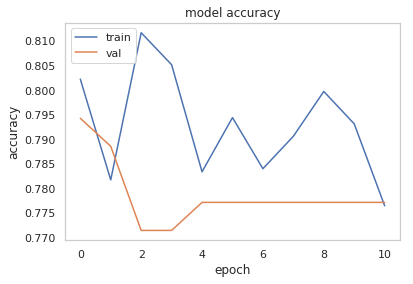

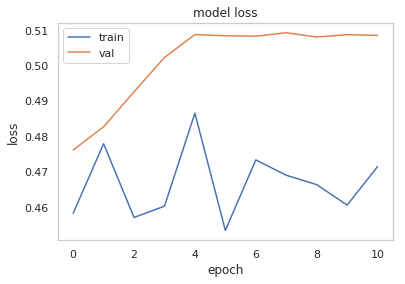

In [146]:
history_plot(his_s_2)


In [147]:
pred_Y_s = model_s.predict(test_X, 
                          verbose = True)

195/195 [==============================] - 1s 4ms/step


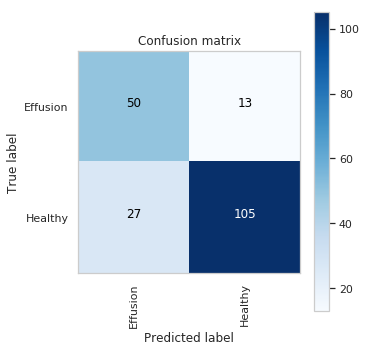

In [148]:
cm=confusion_matrix(test_Y.argmax(axis=1),pred_Y_s.argmax(axis=1))
plot_confusion_matrix(cm, classes = list(dict_pathology.values()))


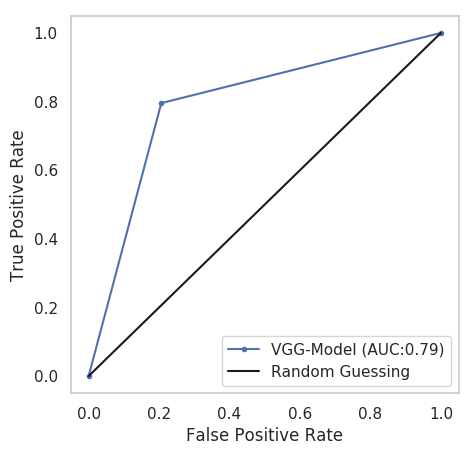

In [149]:
fpr, tpr, _ = roc_curve(test_Y.argmax(axis=1), pred_Y_s.argmax(axis=1))
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y.argmax(axis=1), pred_Y_s.argmax(axis=1)))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')

In [150]:
pred_Y_s[pred_Y_s>0.5] = 1 # Switch from probabilities to class
pred_Y_s[pred_Y_s<=0.5] = 0
print(classification_report(test_Y, pred_Y_s, target_names = ['Effusion', 'Healthy']))

              precision    recall  f1-score   support

    Effusion       0.65      0.79      0.71        63
     Healthy       0.89      0.80      0.84       132

   micro avg       0.79      0.79      0.79       195
   macro avg       0.77      0.79      0.78       195
weighted avg       0.81      0.79      0.80       195
 samples avg       0.79      0.79      0.79       195

